In [60]:
from astropy.io import ascii
import glob
import matplotlib.pyplot as plt

import numpy as np
from scipy import asarray as ar, exp
from scipy.optimize import curve_fit, least_squares
import re
%matplotlib inline

snls_colors = {"sdssg":"darkgreen", "sdssi":"darkblue", "sdssr":"darkred", "sdssz":"purple"}
base_colors = {"sdssg":"green", "sdssi":"blue", "sdssr":"red", "sdssz":"magenta"}

import astropy.coordinates as coord
import astropy.units as u
import Utils.DiaSourceTools as DSTools
import glob
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist

import sncosmo


from astropy.table import Table

import copy
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
from astropy.time import Time
import numpy as np
import math
from photutils import CircularAperture, aperture_photometry
import pickle

from astropy.time import Time

Important functions 

In [2]:
def show_multi_filter_light_curve(t, colors, n_factor = None, conv='.'):
   
    #plt.figure(figsize=(15,10))
    t_by_filter = t.group_by("bandpass")

    indices = t_by_filter.groups.indices
    
    #print indices
    for i in range(0, len(indices)-1):
        
        data = t_by_filter[indices[i]:indices[i+1]]
        
        if n_factor is not None:
            value = n_factor[data[0]["bandpass"]]
            f = value if np.isnan(value) == False else 1
            plt.errorbar(data["mjd"], data["flux"]*f,yerr=data["flux_error"]*f, fmt=conv, markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])            
        else:
            plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt=conv, markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])
    plt.legend()
    #plt.show()
    
def match_with_lc(snls_array, stack_lc):
    matches = []
    for lc in snls_array:
        #print "light curve"
        val = {"ra":lc[0]["ra"], "dec":lc[0]["dec"]}
        #print np.rad2deg(lc[0]["ra"]), np.rad2deg(lc[0]["dec"])
        for i, slc in enumerate(stack_lc):

            comp = {"ra":np.mean(slc["ra"]), "dec":np.mean(slc["dec"])}
            if DSTools.source_distance(val, comp)<1:
                print i
                matches.append((lc["id"],lc,slc))


    print len(matches)
    return matches

def mod_gauss(t, a, t0, tf, tr, b):
    return a*((exp(-(t-t0)/tf))/(1+exp(-(t-t0)/tr)))+b

def gauss(x, a, x0, sigma, b):
    return a*exp(-(x-x0)**2/(2*sigma**2))+b


def residuals(p, x, y):
    a, m, s, b = p
    y_fit = gauss(x, a, m, s, b)
    
    err = y - y_fit
    return err

def get_max_index(fluxes):
    max_val = 0
    max_index = -1
    for i, elem in enumerate(fluxes):
        
        if max_val<elem:
            max_val = elem
            max_index = i
            
    return max_index
    
def show_fit_mod_gaussians(t, colors, n_factor = None, plot=True):

    
    t_by_filter = t.group_by("bandpass")

    
    min_date = min(t["mjd"])
    max_date = max(t["mjd"])
    
     
    indices = t_by_filter.groups.indices
    max_i = get_max_index(t_by_filter["flux"])
    mean_date = t_by_filter[max_i]["mjd"]-min_date
    
  
    for i in range(0, len(indices)-1):

        data = t_by_filter[indices[i]:indices[i+1]]
        x = data["mjd"]-min_date
        y = data["flux"]
        
        n = len(x)
        sigma = np.std(y)
        
      
        popt, pcov = curve_fit(mod_gauss, x, y, p0=[1, mean_date, 2, 1, 0], maxfev=50000,  sigma = data["flux_error"])
        
        
        c = (y - mod_gauss(x, *popt))
        chi = (y - mod_gauss(x, *popt))/data["flux_error"]
    
        chi2 = (chi**2).sum()
        dof = len(x) - len(popt)

        #print len(x) - len(popt)
        #print (chi2 / (len(x)-len(popt)))
        if plot==True:
            plt.plot(x, y, 'b+', color=colors[data[0]["bandpass"]])

            X = np.arange(0,max_date-min_date,1)

            plt.plot(X, mod_gauss(X, *popt), color=colors[data[0]["bandpass"]])
        #print gauss(X, *popt)
        #plt.xlim(xmin=400, xmax=500)
        #plt.show()
        #plt.legend()
    #plt.show()
    return popt, pcov, chi2, dof


In [3]:
f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
#elems = re.findall('^(.*?D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)
elems = re.findall('^((04|05|06)D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)
f.close()

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()
f.close()


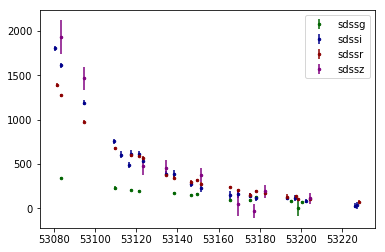

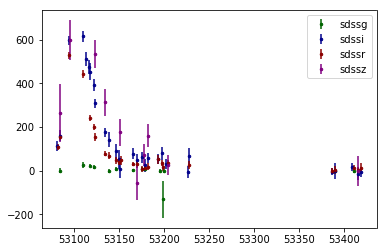

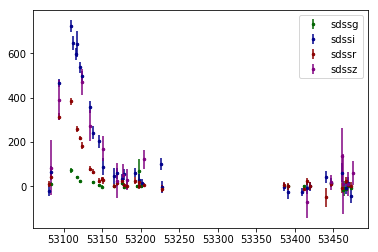

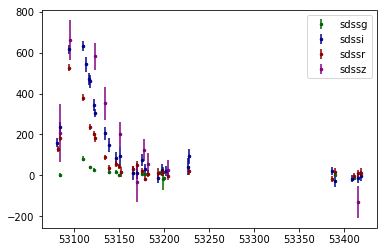

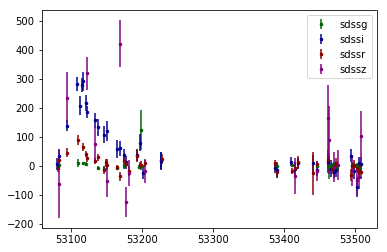

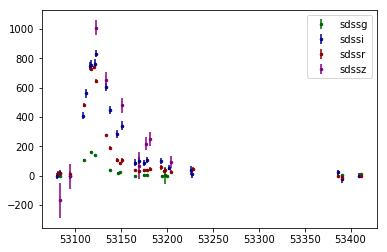

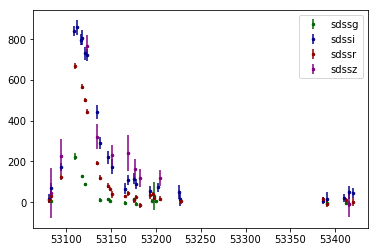

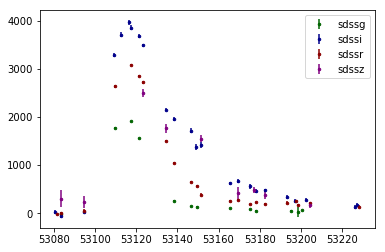

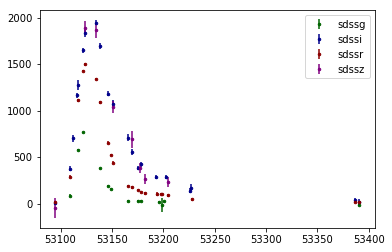

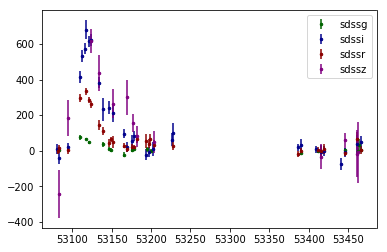

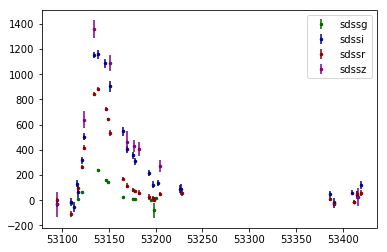

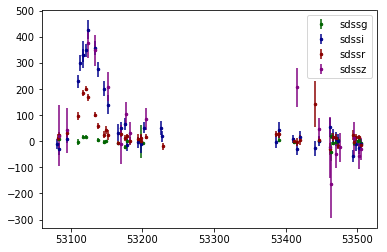

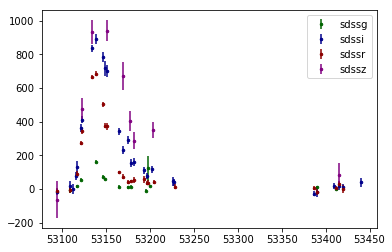

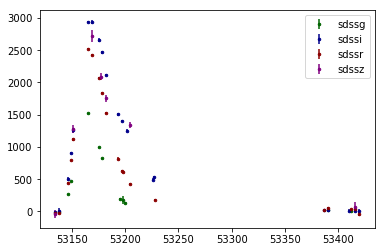

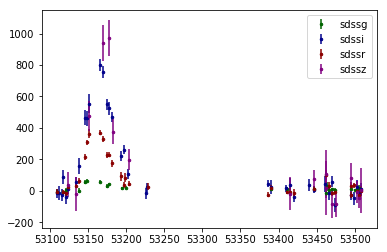

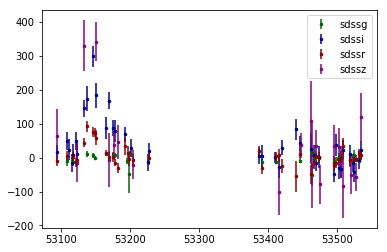

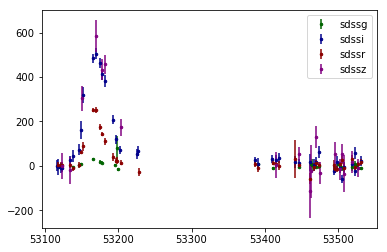

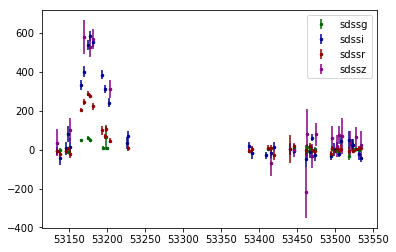

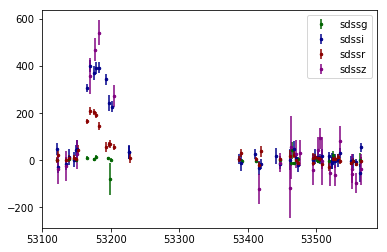

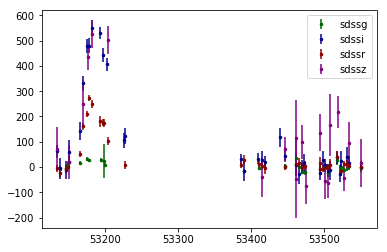

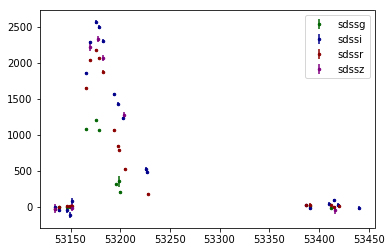

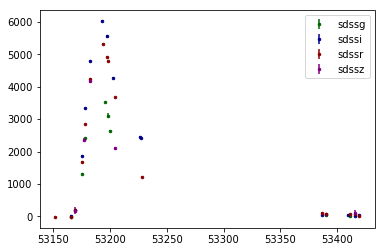

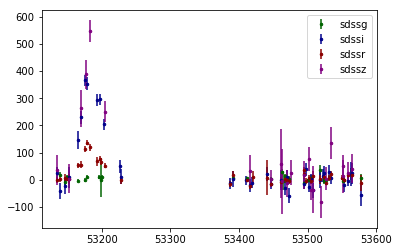

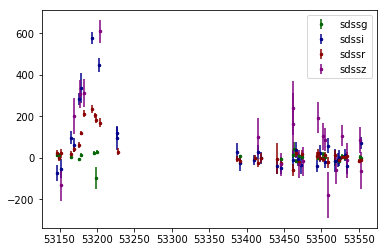

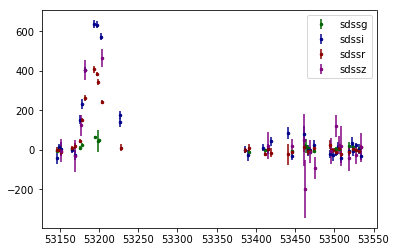

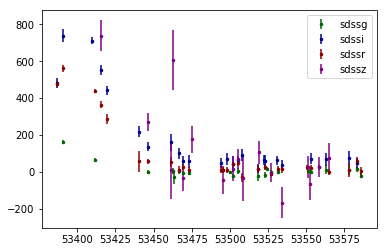

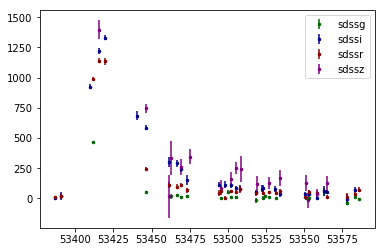

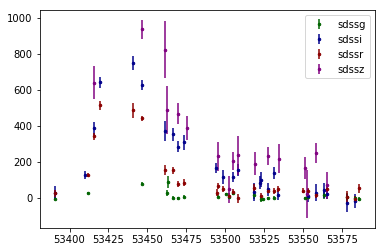

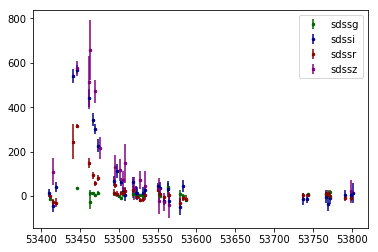

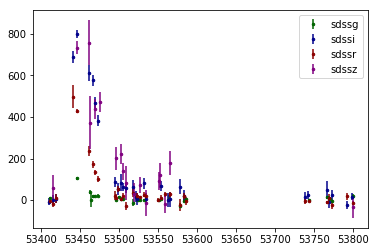

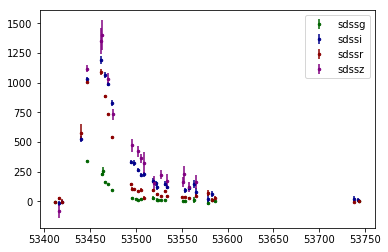

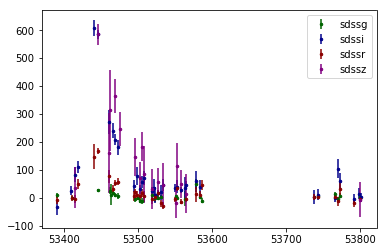

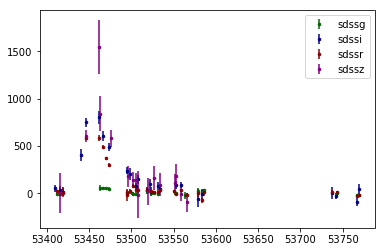

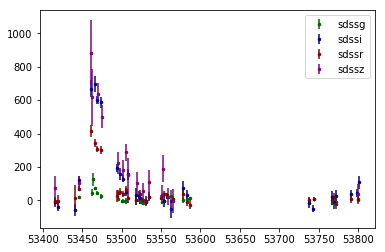

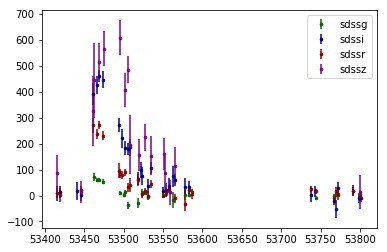

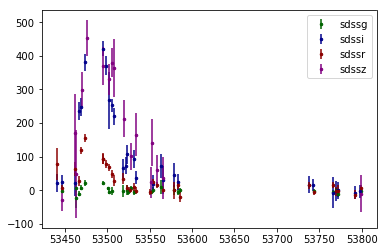

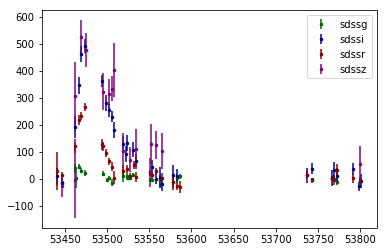

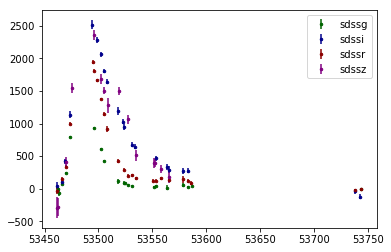

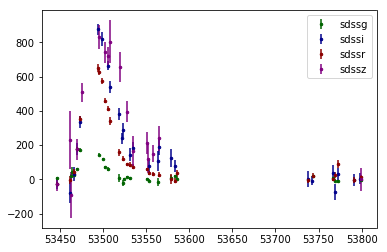

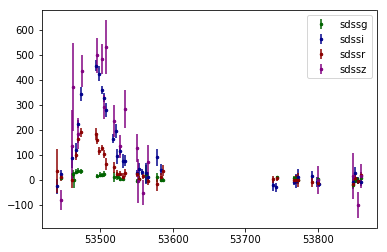

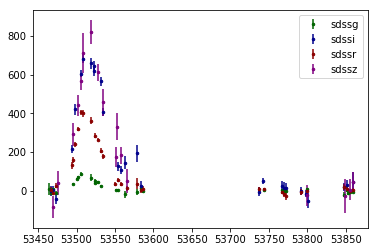

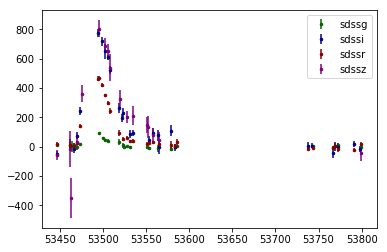

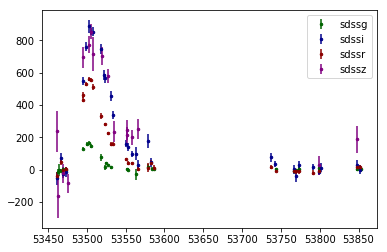

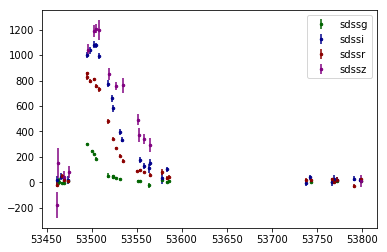

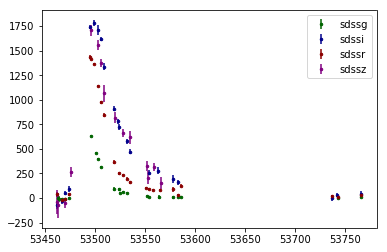

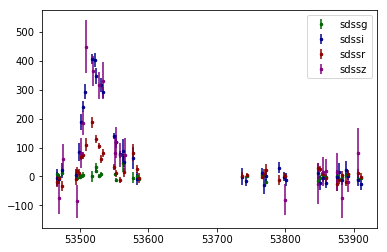

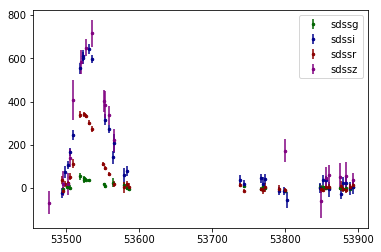

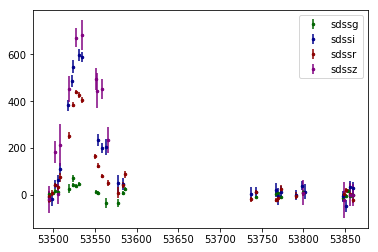

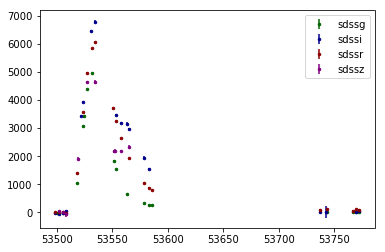

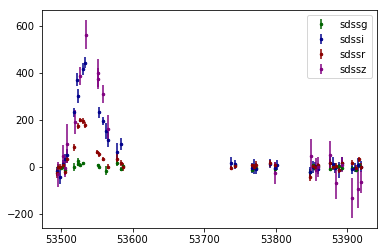

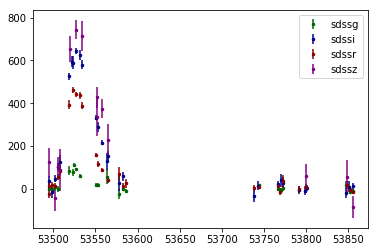

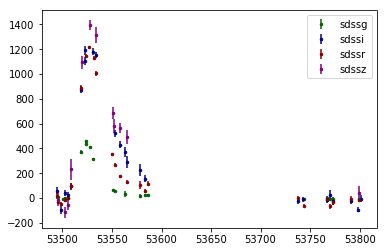

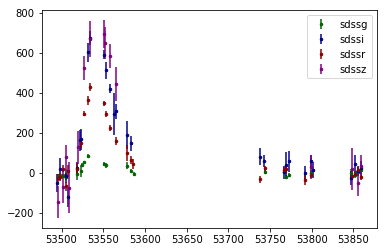

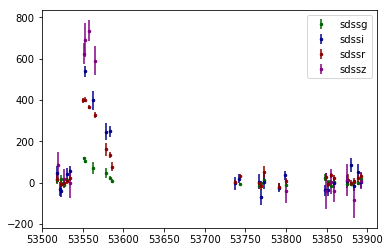

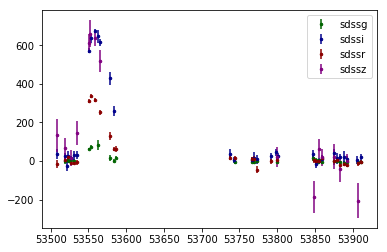

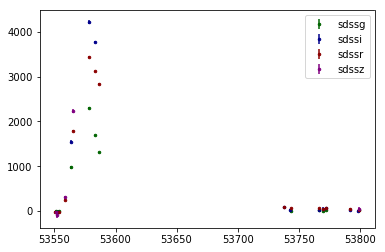

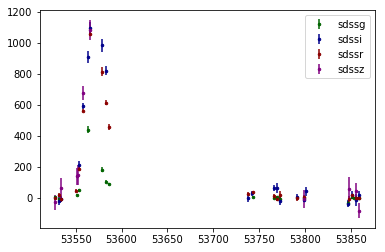

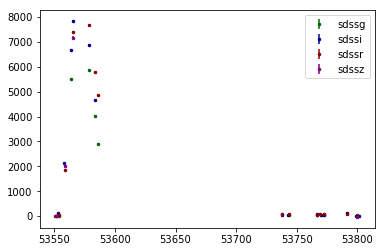

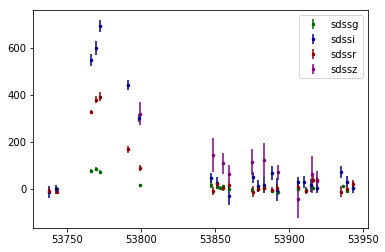

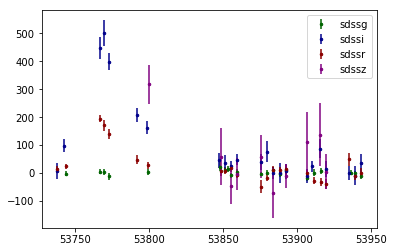

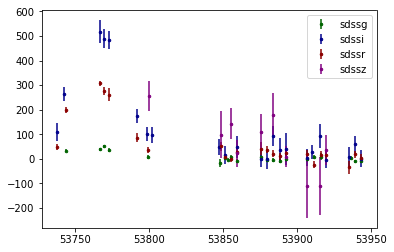

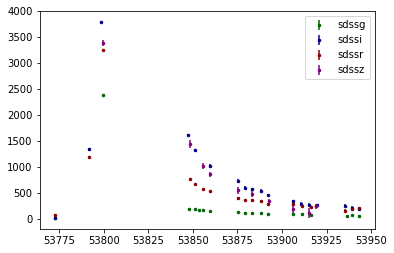

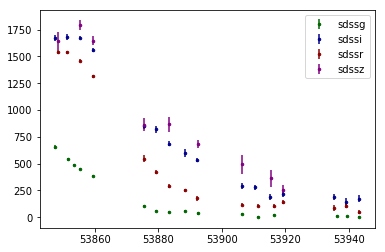

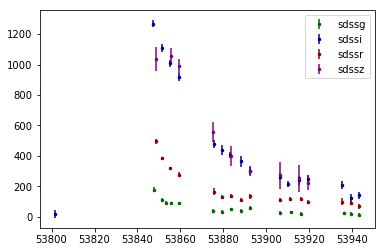

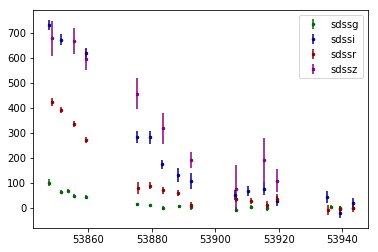

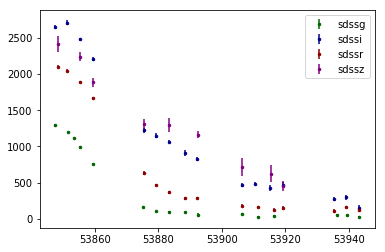

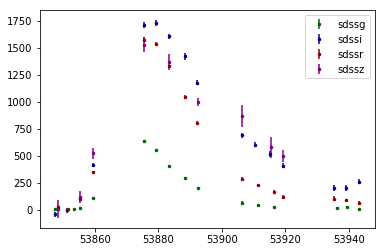

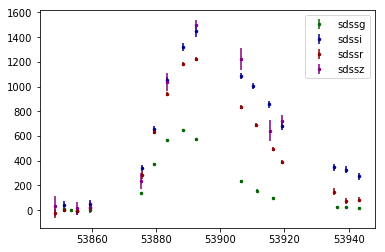

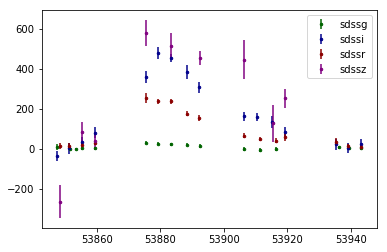

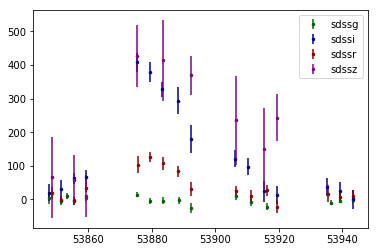

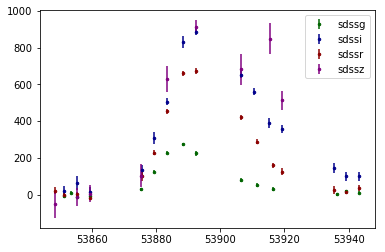

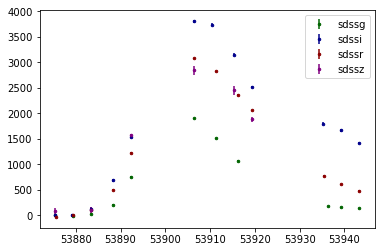

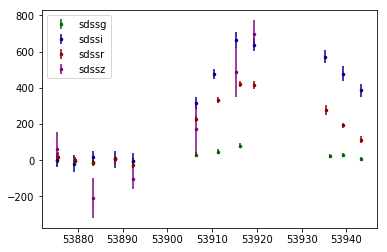

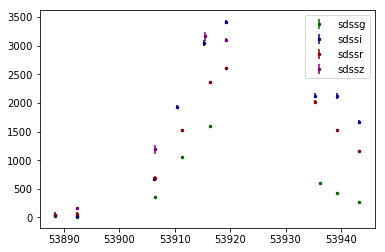

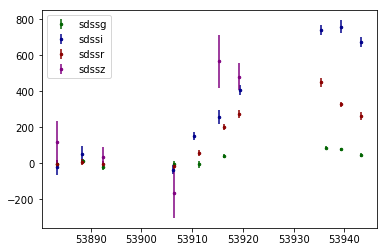

total of sn:75


In [4]:
snls_array = []
for sn in elems:

        c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))

        m = re.findall('^'+str(sn[0])+'\\|(r|g|z|i)\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)


        snls_lc = DSTools.build_light_curve_from_snls_file_2(m, c, sn[0], sn[-1])

        if len(m)>0:
            #print sn[0], c.ra.deg, c.dec.deg

            #plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
            show_multi_filter_light_curve(snls_lc, snls_colors)
            plt.show()
            snls_array.append(snls_lc)

print("total of sn:" + str(len(snls_array)))


This method opens all the extracted Stack light curves

In [ ]:
lienObj = glob.glob("/datadec/cppm/jpreyes/CFHT_Tests/light_curves_coadd/*.dat")
lcs = []
for oj in lienObj:
    table = ascii.read(oj)
    lcs.append(table)

With this piece of code, we filter light curves with at least 2 curves in the different bands

In [ ]:
s_candidates= []
for lc in lcs:
    t_by_filter = lc.group_by("bandpass")

    indices = t_by_filter.groups.indices
    if len(indices)>=2:
        s_candidates.append(lc)

This also alow us to select only the candidates with at least N points.

In [ ]:
res = None
for s in s_candidates:
    if len(s)>10:
        res = s

Opening the control data: SNLS curves

Extracting and building the sncosmo tables from the SNLS data

Matching the SNLS with Stack. Indexes are the matched curves

In [ ]:
candidates_copy = copy.deepcopy(s_candidates)

In [9]:
len(s_candidates)

440822

In [10]:
matches_sc = match_with_lc(snls_array, s_candidates)

163691
58213
165776
166853
70829
86010
160735
220534
132710
77825
388461
390874
67849
180137
201835
213356
217115
238134
112415
286423
291900
301379
425268
3642
4611
299244
68748
26946
96540
101297
162536
234845
96013
143169
25076
26255
14686
350055
358319
113047
126430
147716
182589
141698
157492
425225
428529
278599
282674
292728
403318
409211
410164
98399
273129
115848
4236
4511
4571
6142
7135
7469
308953
315839
316167
316908
250183
315425
364535
120334
398915
400783
197306
262853
310706
35081
37774
164935
23212
23250
195029
82131
82514
171256
180170
160286
76295
82364
55233
169098
180774
296650
298927
299826
409776
82635
375678
188943
190604
171935
194905
1881
224542
5996
236192
251753
146043
149261
17001
33403
201320
34400
429188
204081
209532
211619
81534
82525
86281
24995
31121
4672
4723
386925
61403
63315
69802
72621
319795
81342
86516
88405
219294
237010
239449
242240
208006
229504
81882
31306
186811
287485
301643
391875
396486
379040
381553
384828
195888
215415
225023
252389


In [11]:
len(matches_sc)

153

In [64]:
def loop_dayfile(dayfile, filter, new_lc, coord, skymap):
    positions = []
    
    tcts = skymap.findClosestTractPatchList([coord])
    tinfo = tcts[0]
    pinfo =tinfo[1][0]
    pindex = pinfo.getIndex()
    patch = str(pindex[0]) +","+str(pindex[-1])
    
    #print patch
    
    for day in dayfile:

        row = []
        t = Time(day, format='iso')
        d_iso = t.iso.split(" ")[0]

  

        if butler.datasetExists("dayCoadd", dataId={"tract":0, "filter":filter,"patch":patch, "date":d_iso}):
            
            dCoadd = butler.get("dayCoadd", dataId={"tract":0, "filter":filter,"patch":patch, "date":d_iso})


            if len(positions)==0:

                wcs = dCoadd.getWcs()
                corner = afwGeom.Point2I(dCoadd.getX0(), dCoadd.getY0())
                coord_pix = wcs.skyToPixel(coord)
                apertures = CircularAperture([coord_pix - corner], r=4.5)



            data = dCoadd.getMaskedImage().getImage().getArray()
            phot_table = aperture_photometry(data, apertures)
            
            new_lc["mjd"].append(t.mjd)
           
            new_lc["flux"].append(phot_table[0]["aperture_sum"])
            new_lc["flux_error"].append(0)
            new_lc["bandpass"].append("sdss"+filter)
            print phot_table[0]["aperture_sum_err"]
            break
    return new_lc

In [15]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Tests"
directory = DATADIR+"/tests/"
butler = dafPersist.Butler(directory) 
filter = 'r'

In [16]:
days_r = []
days_i = []
days_g = []
days_z = []
with open(DATADIR+"/days_r.txt", "rb") as dayFile:
    for line in dayFile:
            line = line.replace('\n','')
            #text = re.split("=| ",line)
            days_r.append(line)
            
with open(DATADIR+"/days_i.txt", "rb") as dayFile:
    for line in dayFile:
            line = line.replace('\n','')
            #text = re.split("=| ",line)
            days_i.append(line)
            
with open(DATADIR+"/days_g.txt", "rb") as dayFile:
    for line in dayFile:
            line = line.replace('\n','')
            #text = re.split("=| ",line)
            days_g.append(line)
            
with open(DATADIR+"/days_z.txt", "rb") as dayFile:
    for line in dayFile:
            line = line.replace('\n','')
            #text = re.split("=| ",line)
            days_z.append(line)
            

In [20]:
import pickle
smap = pickle.load(open(DATADIR+'/tests/deepCoadd/skyMap.pickle', 'rb'))

In [18]:
lc_val = []
for match in matches_sc:
    lc_val.append(match[2])

In [31]:
len(lc_val)

153

In [65]:
corr_lc = []

counter = 2
for lc in lc_val:
    
    
    lc_dcoadd = copy.deepcopy(lc)
    
    ra = lc_dcoadd[0]["ra"]
    dec = lc_dcoadd[0]["dec"]
    
    coord = afwCoord.Fk5Coord(afwGeom.Point2D(ra, dec), afwGeom.radians)
    
    
    new_lc = {}
    new_lc["mjd"] = []
    new_lc["flux"] = []
    new_lc["flux_error"] = []
    new_lc["bandpass"] = []
    
    #new_lc = Table(np.arange(4), names=('mjd', 'flux', 'flux_error', 'bandpass'))
    
    new_lc = loop_dayfile(days_r, "r", new_lc, coord, smap)
    new_lc = loop_dayfile(days_i, "i", new_lc, coord, smap)
    new_lc = loop_dayfile(days_g, "g", new_lc, coord, smap)
    new_lc = loop_dayfile(days_z, "z", new_lc, coord, smap)
           
           

    corr_lc.append(Table(data=new_lc))
    
    
    
    
    

KeyError: 'aperture_sum_err'

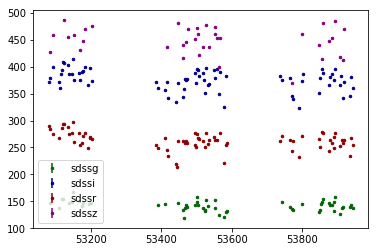

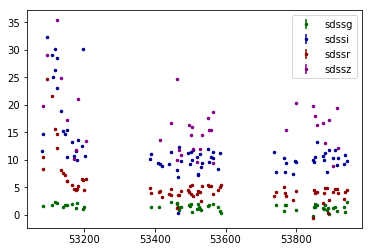

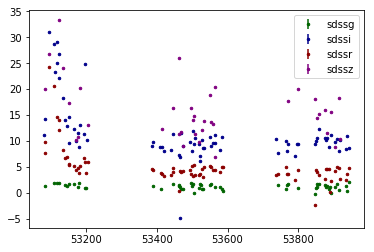

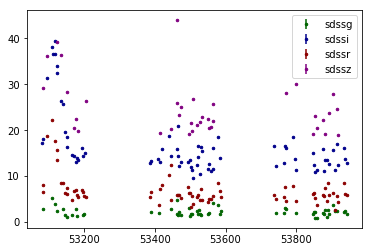

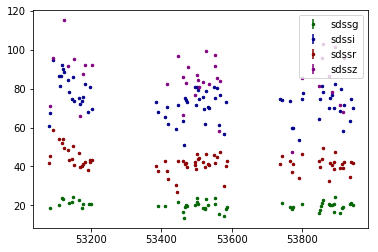

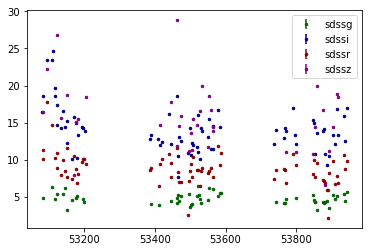

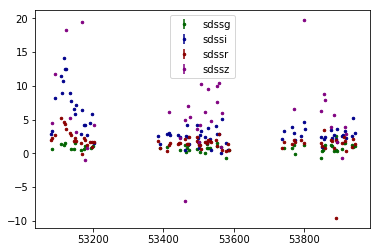

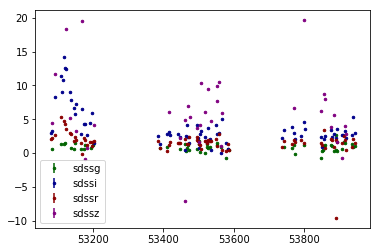

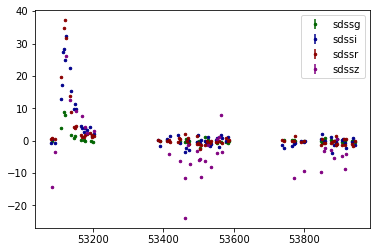

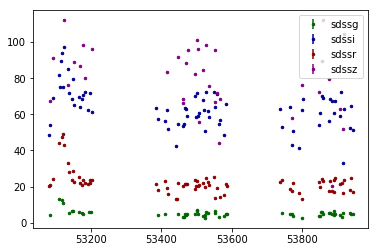

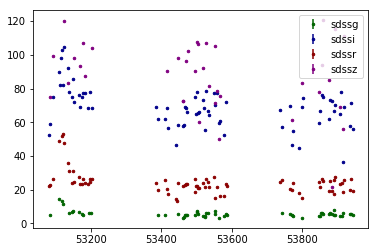

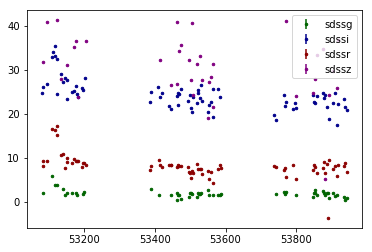

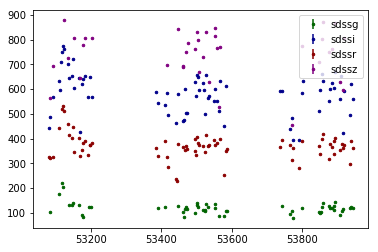

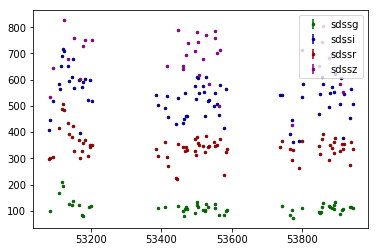

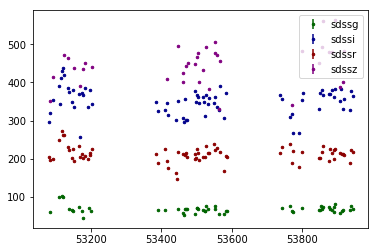

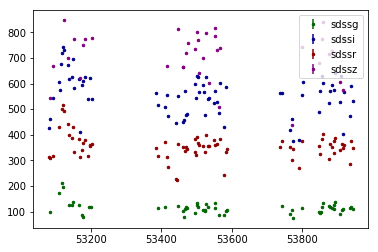

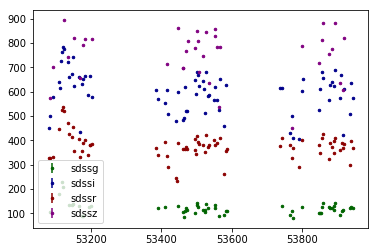

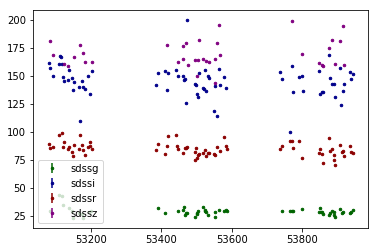

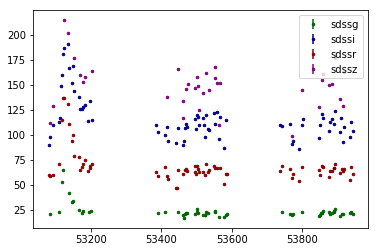

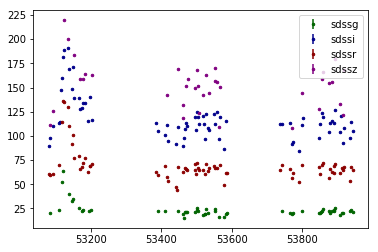

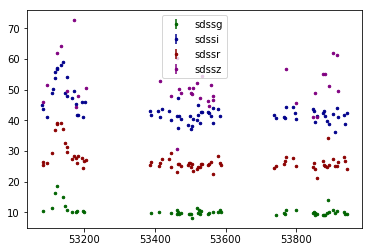

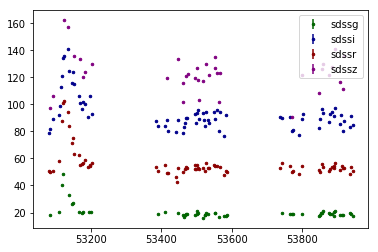

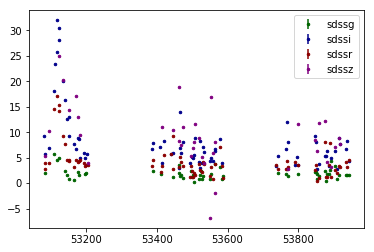

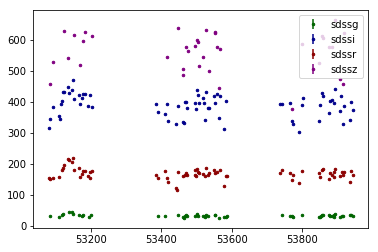

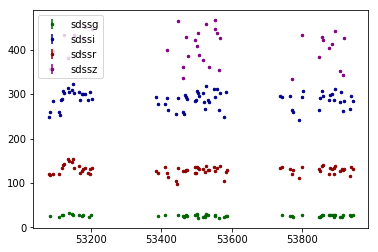

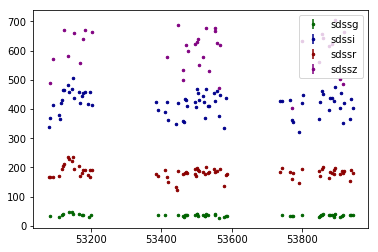

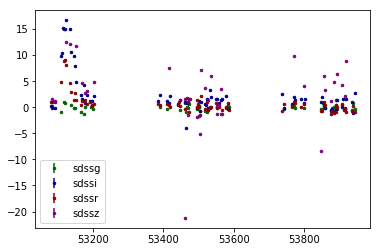

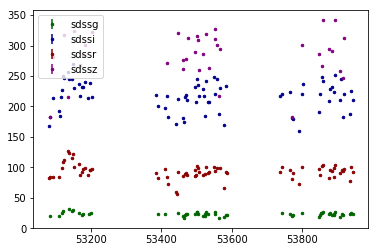

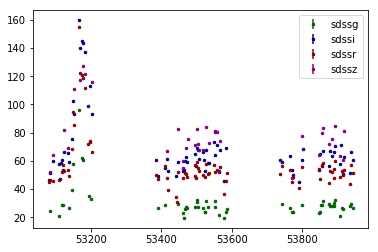

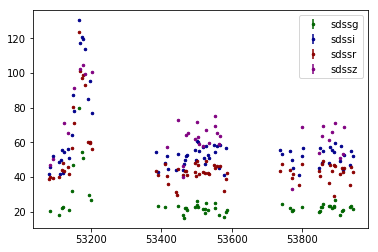

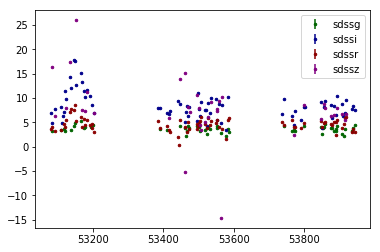

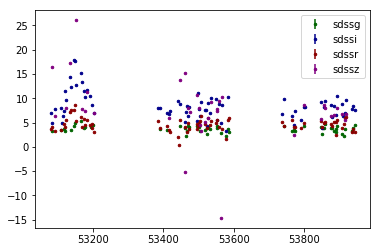

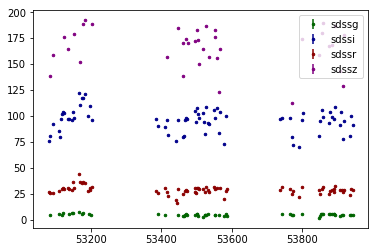

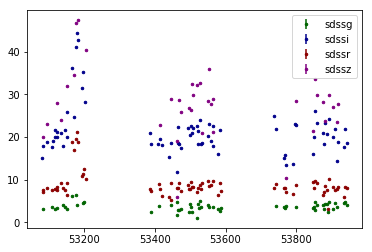

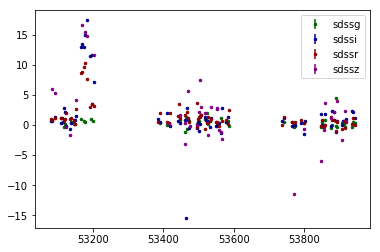

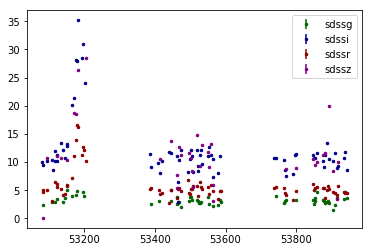

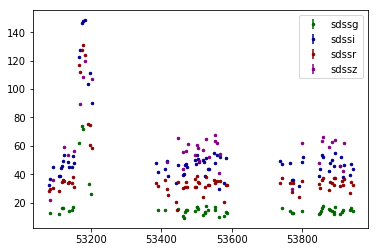

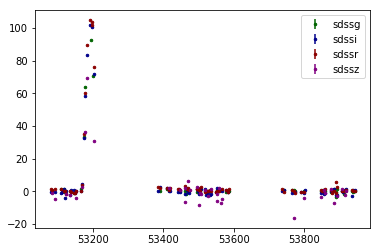

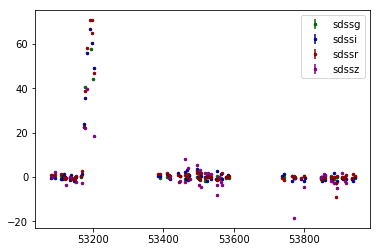

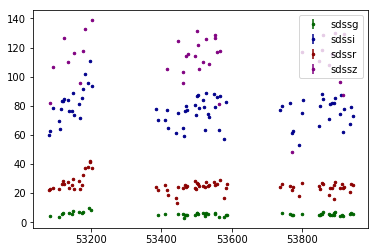

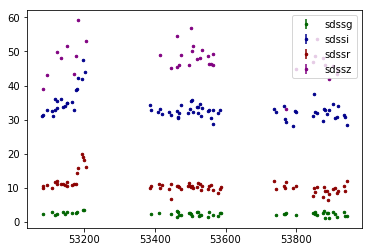

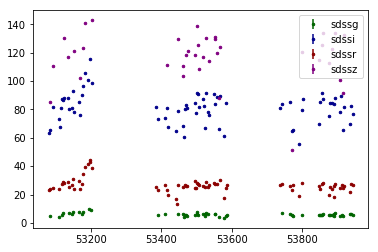

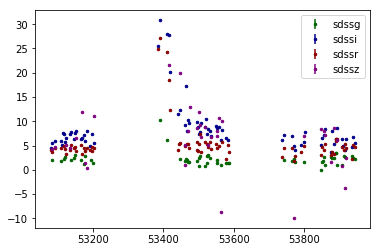

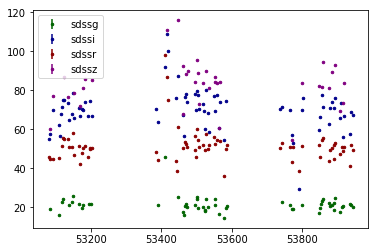

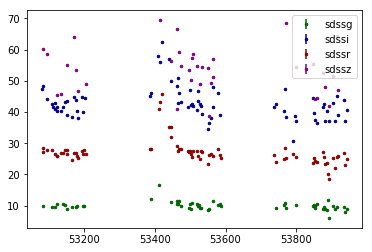

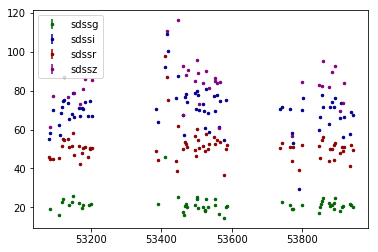

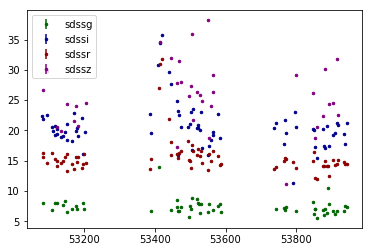

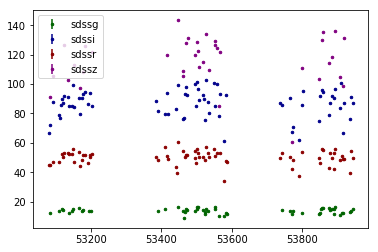

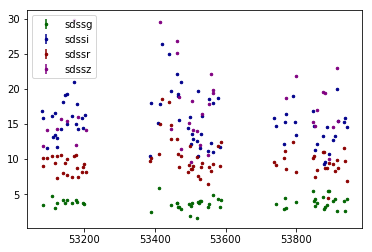

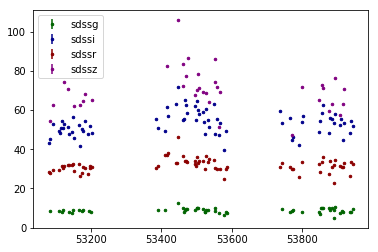

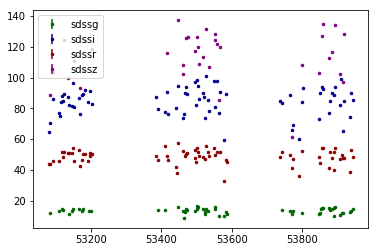

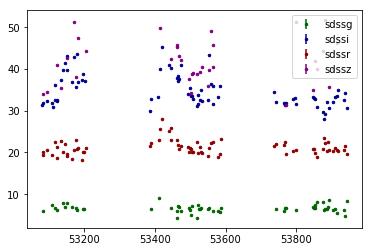

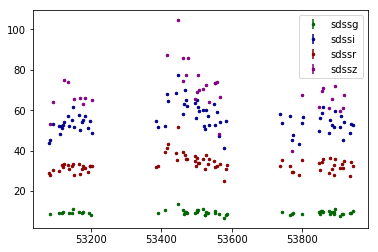

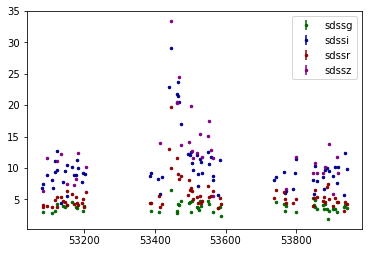

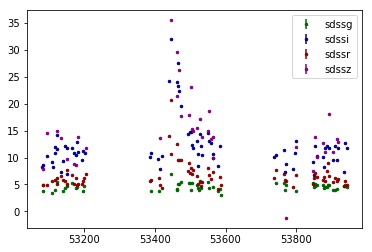

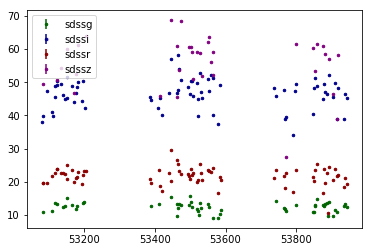

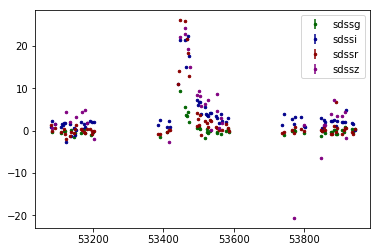

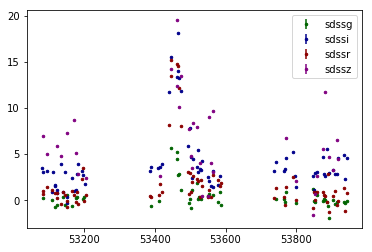

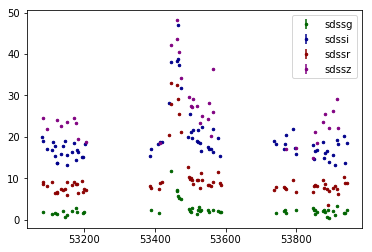

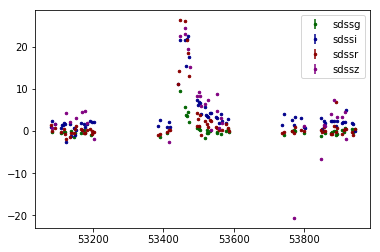

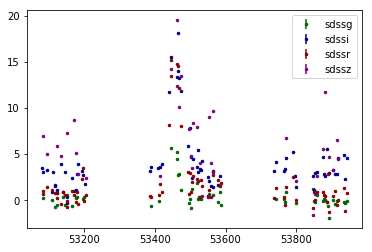

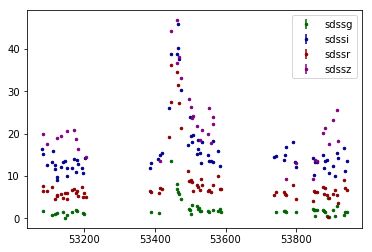

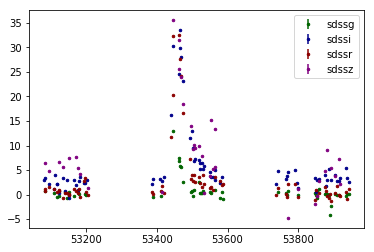

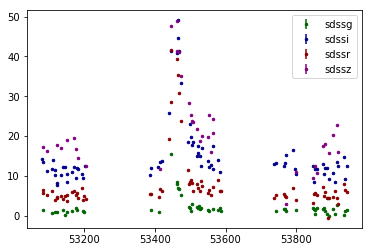

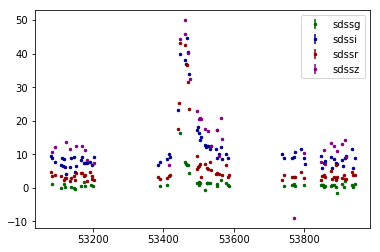

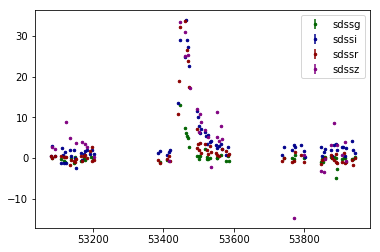

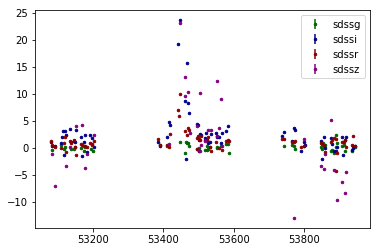

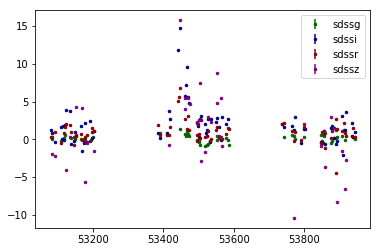

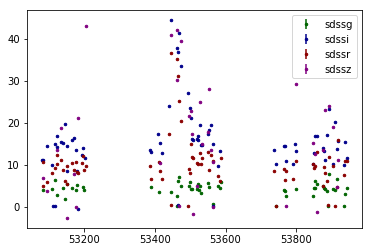

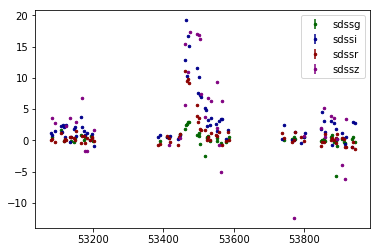

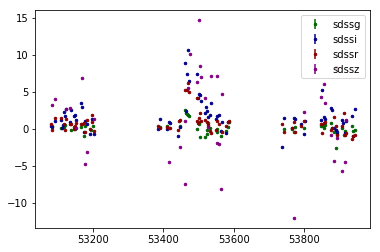

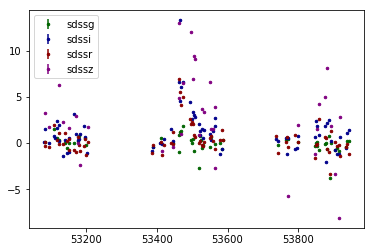

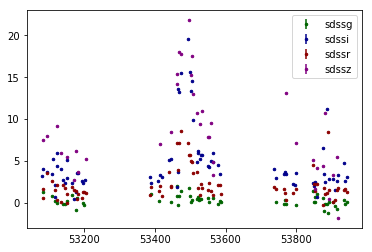

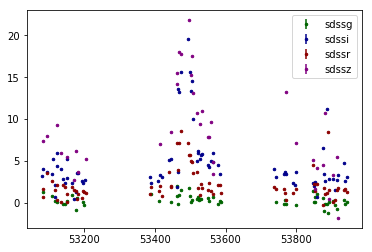

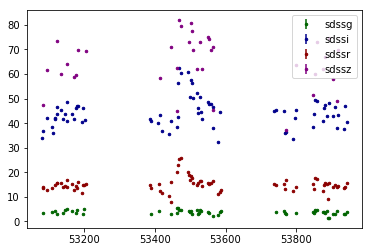

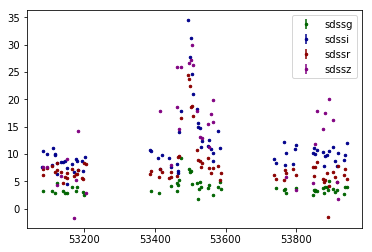

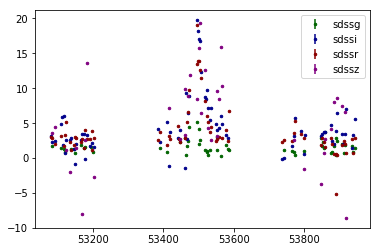

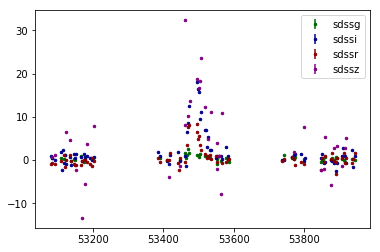

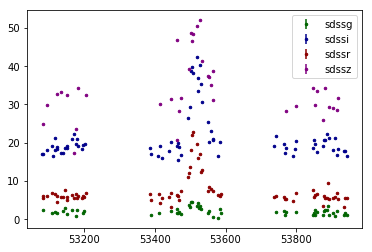

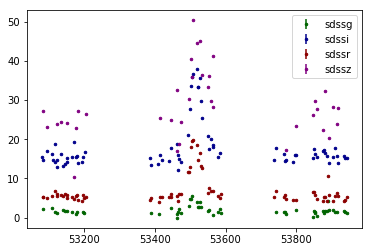

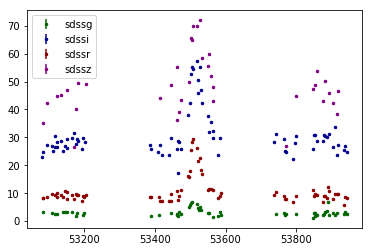

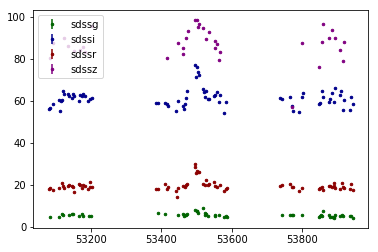

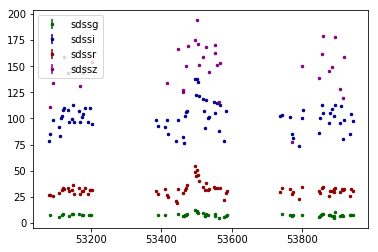

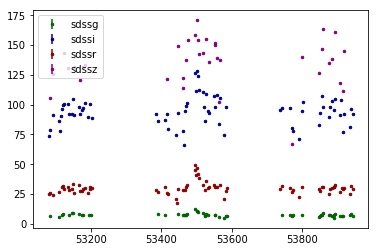

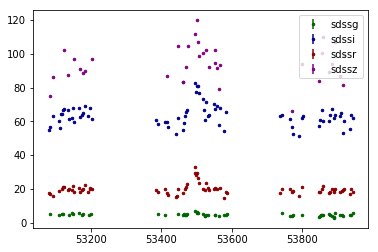

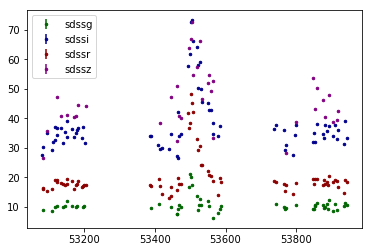

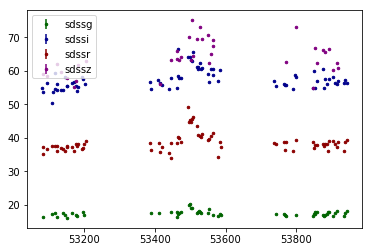

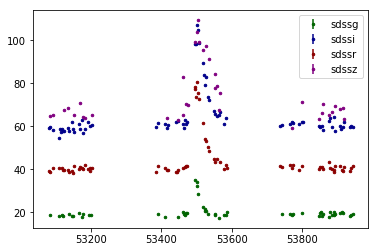

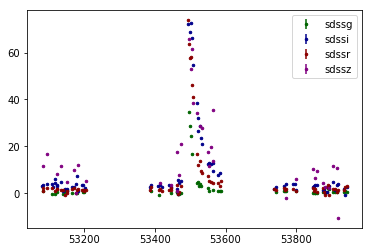

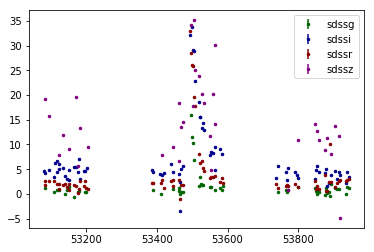

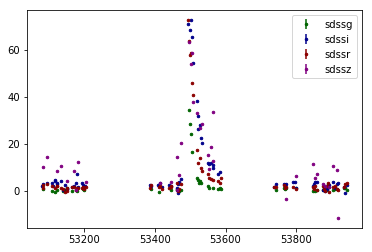

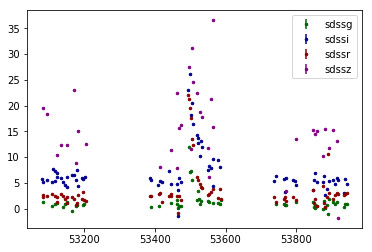

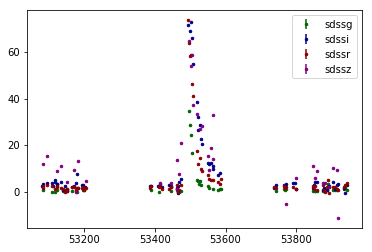

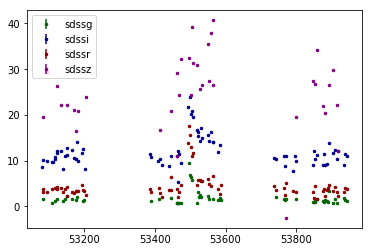

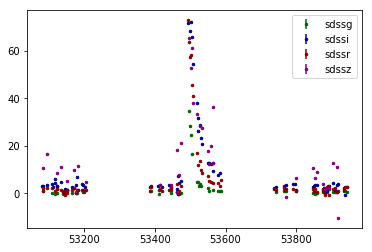

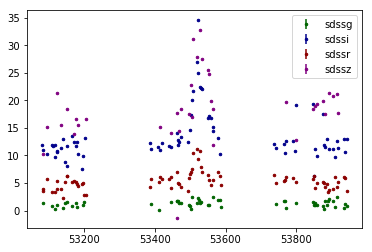

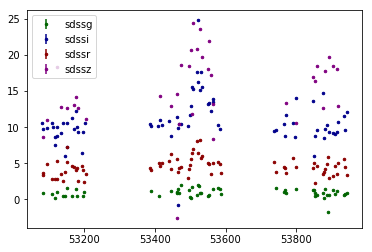

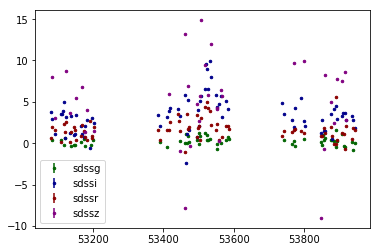

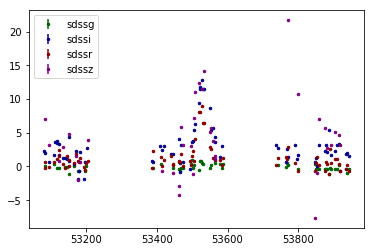

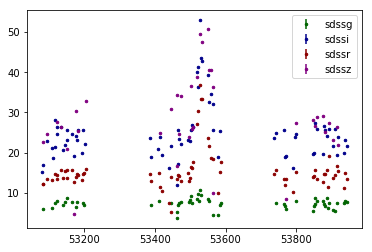

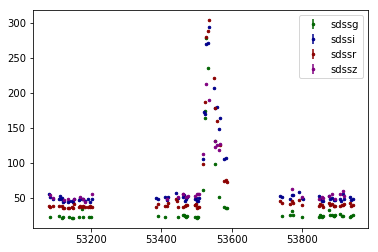

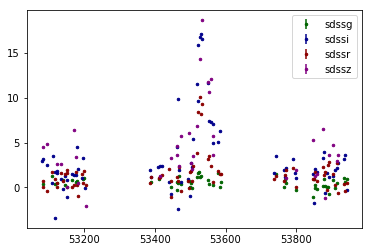

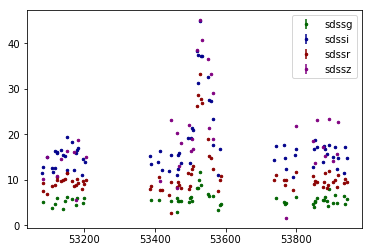

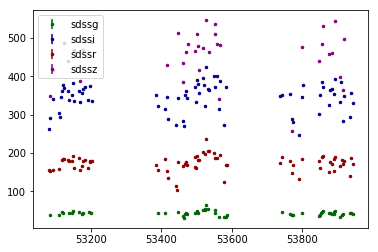

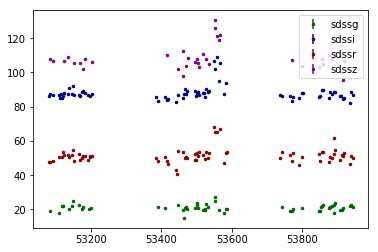

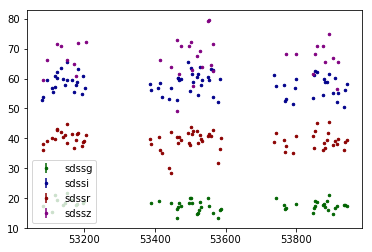

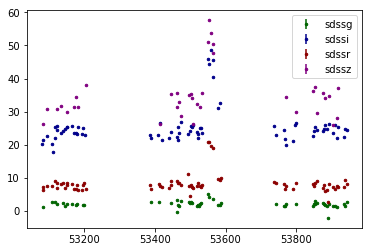

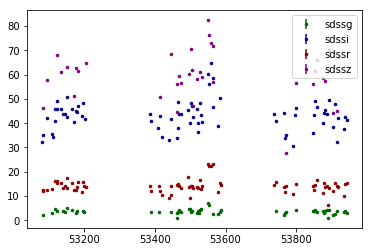

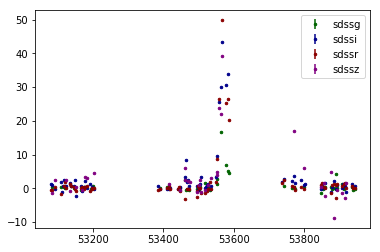

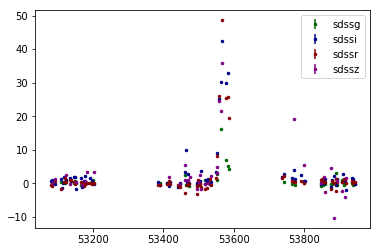

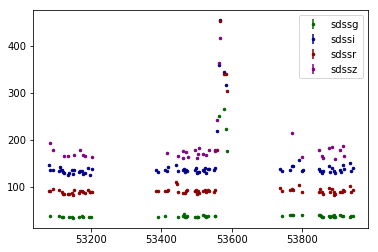

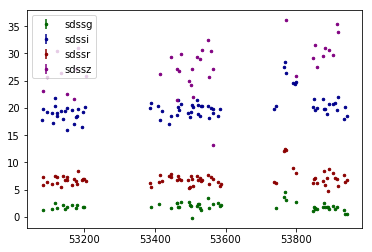

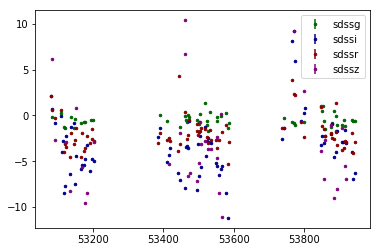

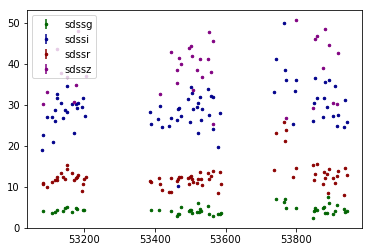

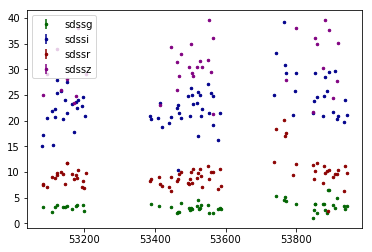

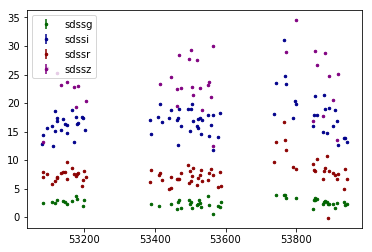

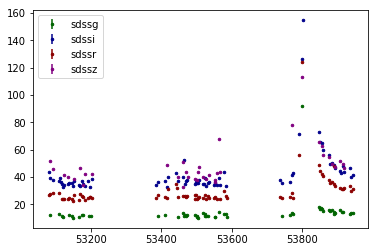

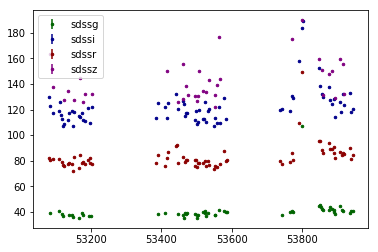

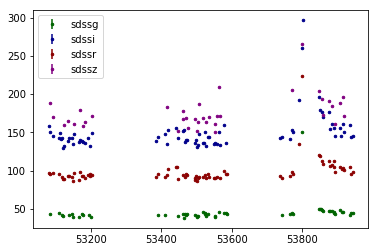

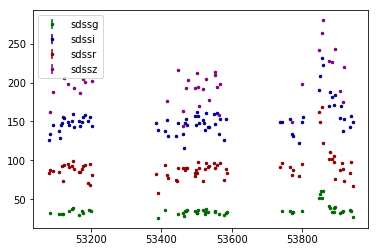

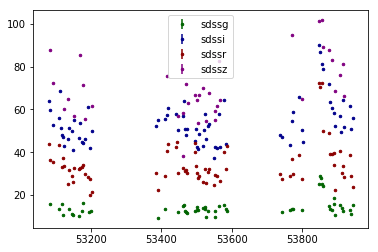

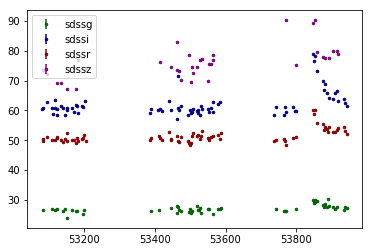

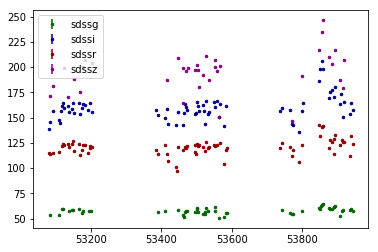

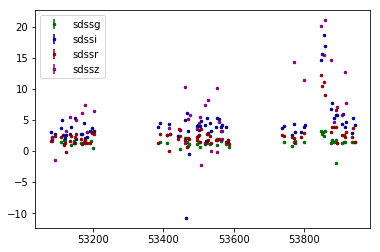

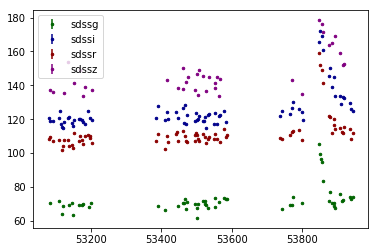

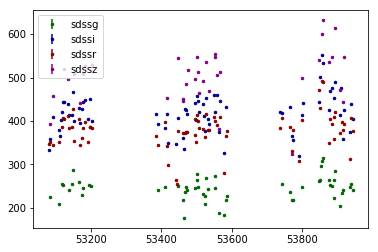

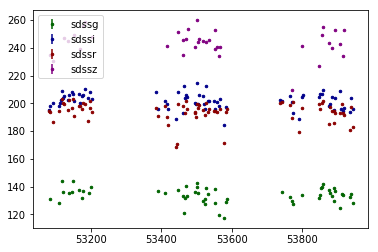

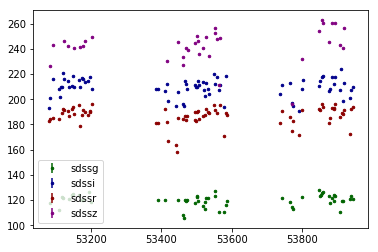

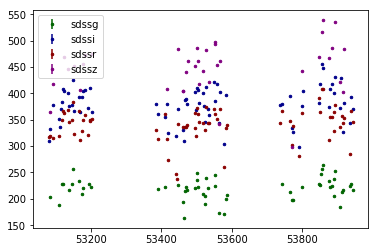

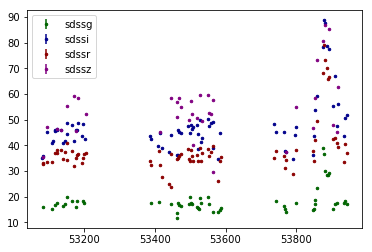

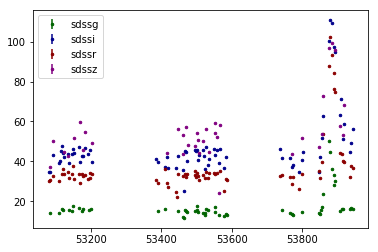

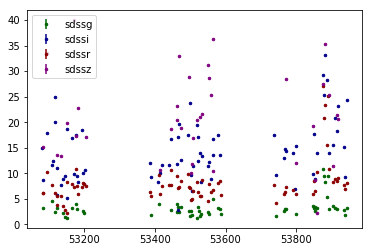

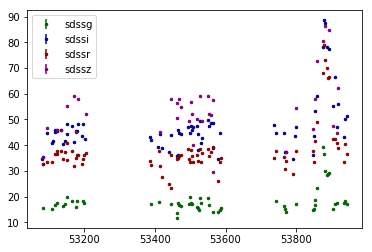

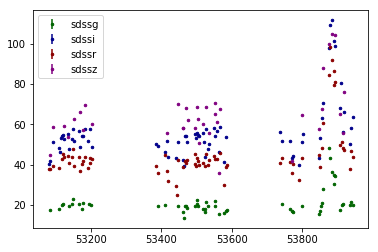

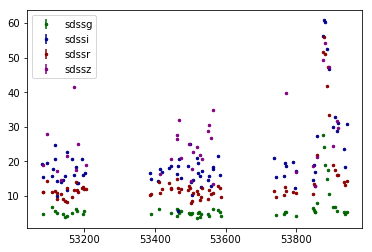

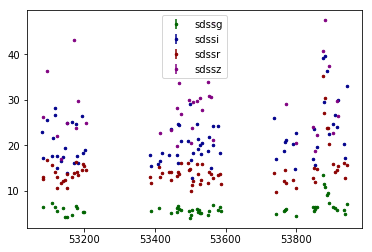

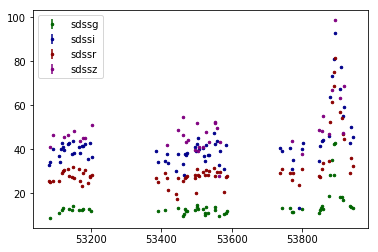

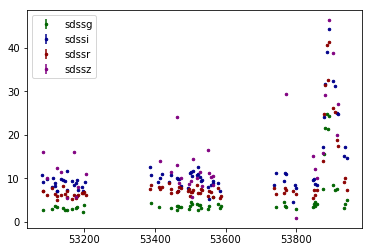

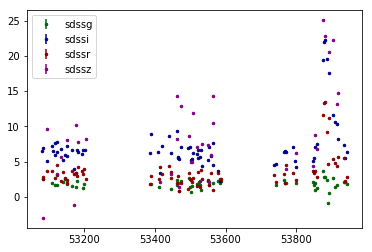

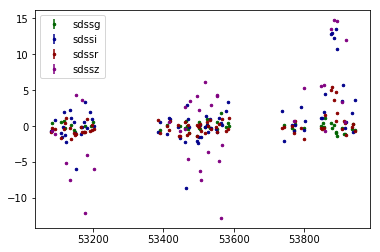

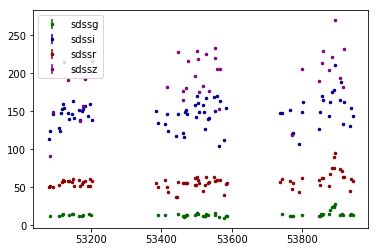

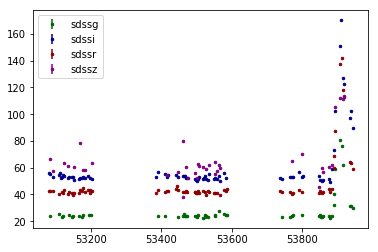

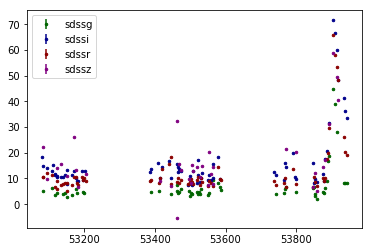

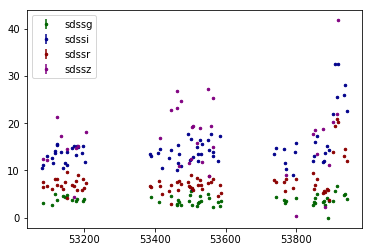

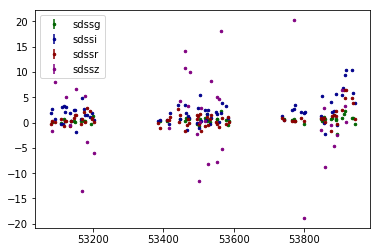

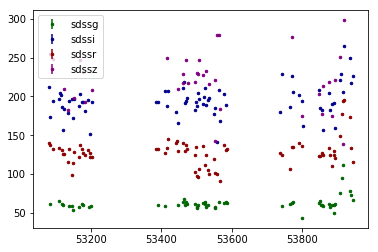

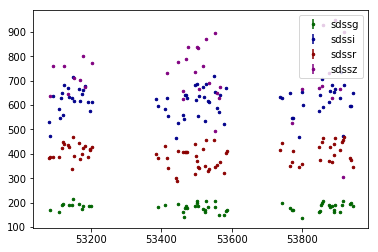

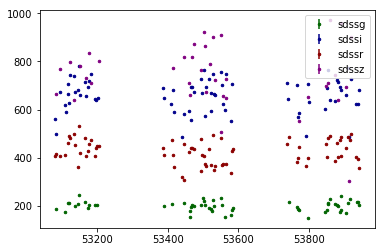

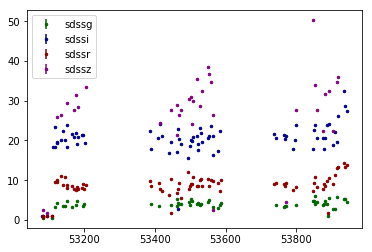

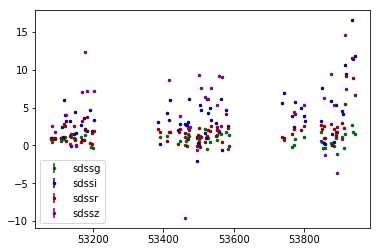

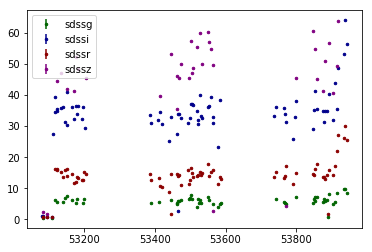

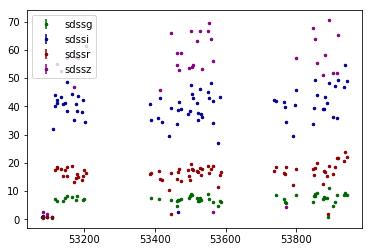

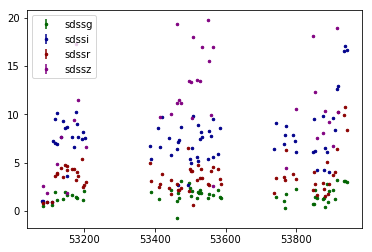

In [58]:
for c_lc in corr_lc:

    show_multi_filter_light_curve(c_lc, snls_colors)
    plt.show()